# **SIC5 2024** *Technical Assignment 2: Predict Machine Failure*

```shell
Name  : Bayu Siddhi Mukti
Group : 6
```

**Objective**:
- Develop a machine learning model to predict tool wear failures in a milling machine based on sensor data.
- Early prediction of tool wear can significantly reduce production downtime and maintenance costs.

# **Import Libraries**

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# **Get the Data**

The data that will be used is **The AI4I 2020 Predictive Maintenance Dataset** data, which is a synthetic data collection that represents real predictive maintenance data found in industry. Data obtained from *UC Irvine Machine Learning Repository*, using the `ucimlrepo` library, on the page https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset.

In [2]:
# Fetch dataset
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601)

In [3]:
# Get the data as pandas dataframes
original = ai4i_2020_predictive_maintenance_dataset.data.original
dataset = ai4i_2020_predictive_maintenance_dataset.data.original
X = ai4i_2020_predictive_maintenance_dataset.data.features 
y = ai4i_2020_predictive_maintenance_dataset.data.targets 

# **Explore the Data**

## **Data Details**

The UCI ML Repository dataset structure is divided into 3 parts, namely `data`, `metadata`, and `variables`.

- **`data`**: Contains data in the form of **pandas** dataframes
  - `ids`: The ID column of the dataframe
  - `features`: Feature columns of the dataframe
  - `targets`: Target column of the dataframe
  - `original`: Dataframe contains all IDs, features, and targets
  - `headers`: List of all variable names
- **`metadata`**: Contains metadata information related to the dataset
  - ...
- **`variables`**: Contains all variable details in the form of a dataframe
  - `name`: Variable name
  - `role`: Role variable (ID, feature, or target)
  - `type`: Data type, such as categorical, integer, or continuous, etc.
  - `demographic`: Informs whether the variable represents demographic data
  - `description`: Short description of the variable
  - `units`: Units of non-categorical variables
  - `missing_values`: Informs whether there are missing values ​​in the variable column

In [4]:
# View examples of dataset contents
original.sample(5)

,UID,Product ID,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
6367,6368,L53547,L,300.0,309.6,1571,33.1,65,0,0,0,0,0,0
4011,4012,L51191,L,302.2,311.1,1447,52.1,174,0,0,0,0,0,0
8699,8700,M23559,M,297.3,308.7,1655,34.1,21,0,0,0,0,0,0
5436,5437,M20296,M,302.9,312.5,1679,30.9,79,0,0,0,0,0,0
7928,7929,L55108,L,300.6,311.7,1497,43.6,198,0,0,0,0,0,0


In [5]:
# View all detailed variable information from UCI ML Repository
ai4i_2020_predictive_maintenance_dataset.variables

,name,role,type,demographic,description,units,missing_values
0,UID,ID,Integer,None,None,None,no
1,Product ID,ID,Categorical,None,None,None,no
2,Type,Feature,Categorical,None,None,None,no
3,Air temperature,Feature,Continuous,None,None,K,no
4,Process temperature,Feature,Continuous,None,None,K,no
5,Rotational speed,Feature,Integer,None,None,rpm,no
6,Torque,Feature,Continuous,None,None,Nm,no
7,Tool wear,Feature,Integer,None,None,min,no
8,Machine failure,Target,Integer,None,None,None,no
9,TWF,Target,Integer,None,None,None,no


In [6]:
# Detailed variable information of pandas dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   UID                  10000 non-null  int64  
 1   Product ID           10000 non-null  object 
 2   Type                 10000 non-null  object 
 3   Air temperature      10000 non-null  float64
 4   Process temperature  10000 non-null  float64
 5   Rotational speed     10000 non-null  int64  
 6   Torque               10000 non-null  float64
 7   Tool wear            10000 non-null  int64  
 8   Machine failure      10000 non-null  int64  
 9   TWF                  10000 non-null  int64  
 10  HDF                  10000 non-null  int64  
 11  PWF                  10000 non-null  int64  
 12  OSF                  10000 non-null  int64  
 13  RNF                  10000 non-null  int64  
dtypes: float64(3), int64(9), object(2)
memory usage: 1.1+ MB


In [7]:
# View unique values ​​in Type and target variables
print(f"Unique value of variable Type: {X['Type'].unique()}")
for var in y.columns:
    print(f"Unique value of variable {var}: {y[var].unique()}")

Unique value of variable Type: ['M' 'L' 'H']
Unique value of variable Machine failure: [0 1]
Unique value of variable TWF: [0 1]
Unique value of variable HDF: [0 1]
Unique value of variable PWF: [0 1]
Unique value of variable OSF: [0 1]
Unique value of variable RNF: [0 1]


Based on examples of data content and detailed variable information, some information is obtained.

- The dataset contains 14 variables
  - 2 ID Variables
  - 6 feature variables
  - 6 Target variables
- There are no `null` values ​​in the dataset
- Feature and target variables have the data type number
  - Except for var `Type` which is of categorical type `['M' 'L' 'H']`
  - The target variable is of integer type `[0 1]`

Data preparation steps
- Both ID variables are not needed in the ML training process
- Because in this assignment the only target variable is `Machine failure`, the other five target variables will be deleted
- To make it easier to train data in ML, the `Type` variable needs to be encoded into a number. Because 'L' means Low, 'M' means Medium, and 'H' means High, there is ordering in these variables. So the type of encoding that will be carried out is Label Encoding

## **Explanatory Data Analysis**

In [8]:
dataset.describe().round(2)

,UID,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,300.0,310.01,1538.78,39.99,107.95,0.03,0.00,0.01,0.01,0.01,0.00
std,2886.90,2.0,1.48,179.28,9.97,63.65,0.18,0.07,0.11,0.10,0.10,0.04
min,1.00,295.3,305.70,1168.00,3.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2500.75,298.3,308.80,1423.00,33.20,53.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,5000.50,300.1,310.10,1503.00,40.10,108.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,7500.25,301.5,311.10,1612.00,46.80,162.00,0.00,0.00,0.00,0.00,0.00,0.00
max,10000.00,304.5,313.80,2886.00,76.60,253.00,1.00,1.00,1.00,1.00,1.00,1.00


array([[<Axes: title={'center': 'Air temperature'}>,
        <Axes: title={'center': 'Process temperature'}>],
       [<Axes: title={'center': 'Rotational speed'}>,
        <Axes: title={'center': 'Torque'}>],
       [<Axes: title={'center': 'Tool wear'}>, <Axes: >]], dtype=object)

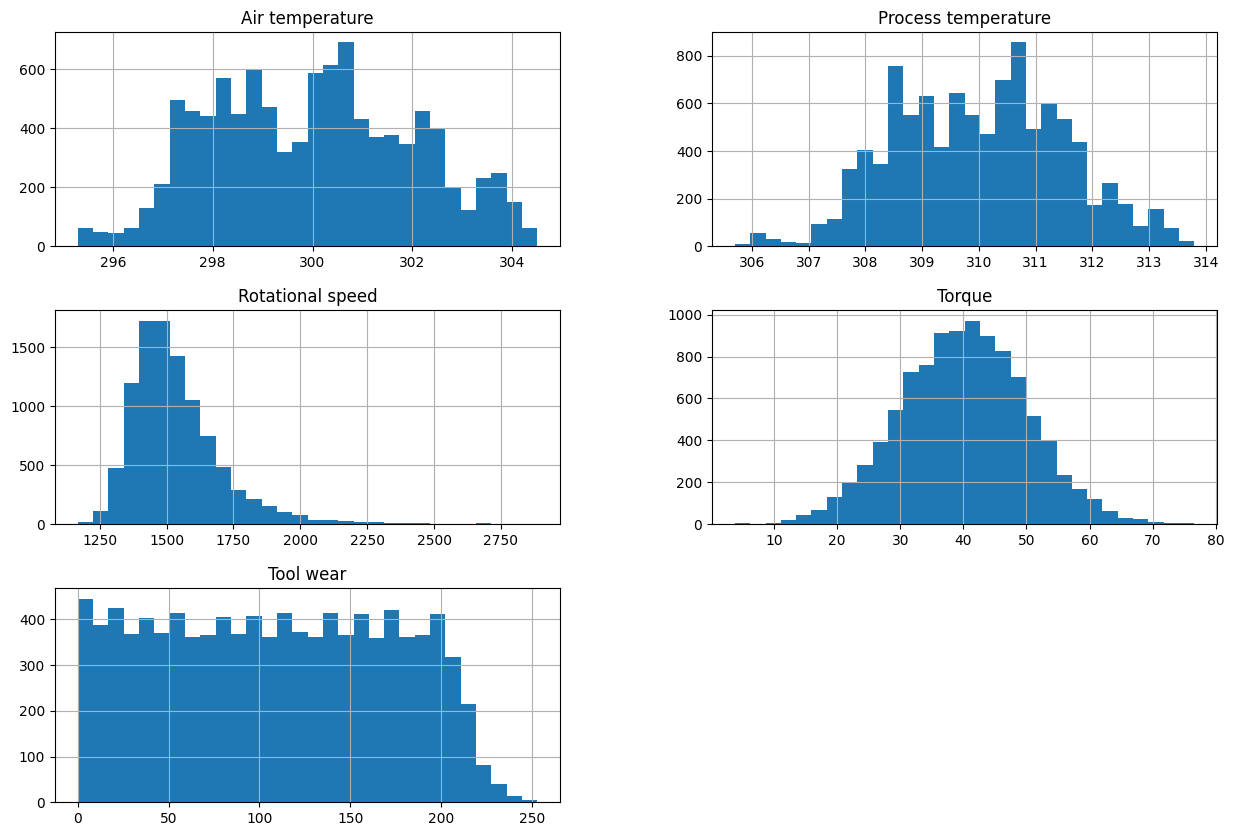

In [9]:
# View the histogram of the numeric feature variable
X.hist(bins=30, figsize=(15, 10))

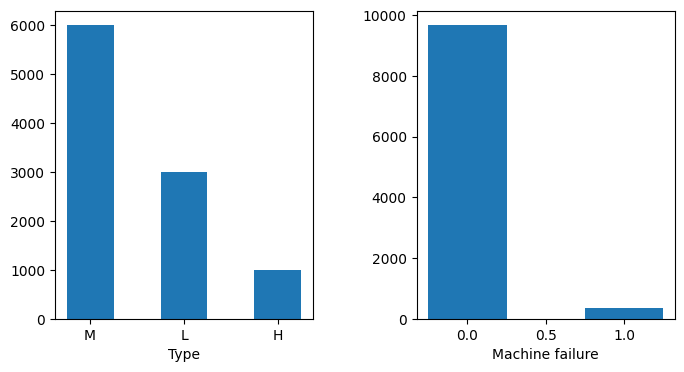

In [10]:
# Bar chart for feature variable 'Type' and target 'Machine failure'
categorical_column = ['Type', 'Machine failure']

plt.figure(num=None, figsize=(8, 4))

for i in range(len(categorical_column)):
    plt.subplot(1, 2, i+1)
    plt.subplots_adjust(wspace=0.4) 
    plt.bar(original[categorical_column[i]].unique(),
            original[categorical_column[i]].value_counts(), width=0.5)
    plt.xlabel(categorical_column[i])

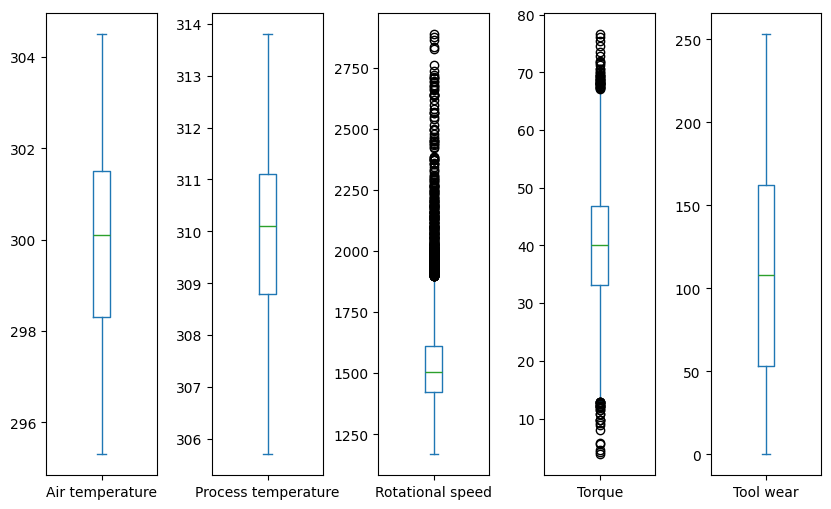

In [11]:
# Boxplot visualization of all numeric feature variables
X.plot(kind='box', subplots=True, sharey=False, figsize=(10, 6))
plt.subplots_adjust(wspace=0.5) 
plt.show()

In [12]:
# Get the percentage of outlier data on the variables 'Rotational speed' and 'Torque'
outlier_columns = ['Rotational speed', 'Torque']

# Get outlier limits
def outlier_bound(datacolumn):
  sorted(datacolumn)  # Memastikan data sudah urut
  Q1, Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_bound = Q1 - (1.5 * IQR)
  upper_bound = Q3 + (1.5 * IQR)
  return lower_bound, upper_bound

# Check the percentage of outlier values ​​in the following two variables
for column in outlier_columns:
  lower_bound, upper_bound = outlier_bound(X[column])
  display(((X[[column]] < lower_bound) | (X[[column]] > upper_bound)).sum().apply(lambda x: '{:.2f}%'.format(x/len(X)*100)))

Rotational speed    4.18%
dtype: object

Torque    0.69%
dtype: object

<Axes: >

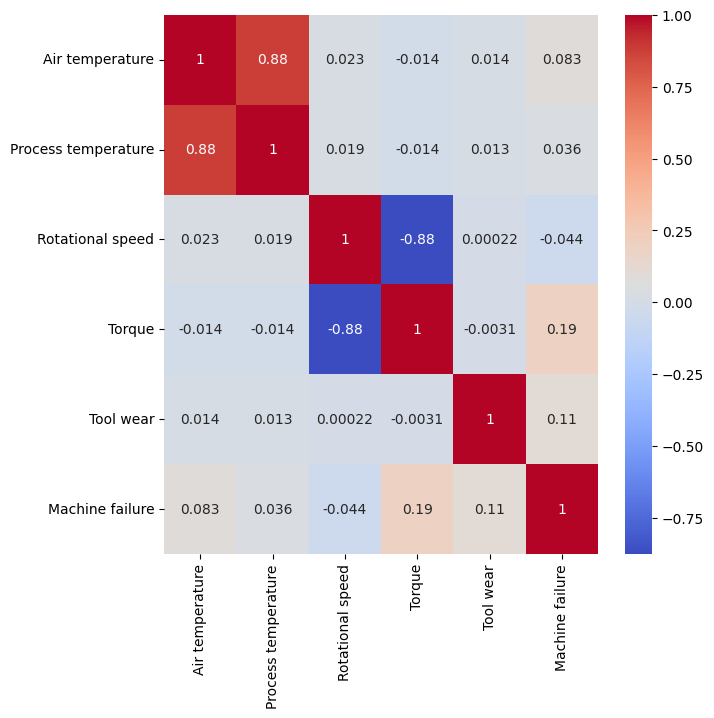

In [13]:
# Calculates the correlation matrix for all numeric feature variables to the target
columns = ['Air temperature', 'Process temperature', 
           'Rotational speed', 'Torque', 'Tool wear', 'Machine failure']

correlation_matrix = original[columns].corr()

# Heatmap correlation matrix visualization
plt.figure(figsize = (7, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

Based on the EDA that has been carried out, several information has been obtained.
- Feature data is quite well distributed
- `Machine failure` target data is very unbalanced
- There are outliers in the `Rotational speed` and `Torque` features, amounting to 4.18% and 0.69%
- There are no features that have a strong relationship with the target
- There is a strong relationship between each feature
  - `Air temperature` and `Process temperature`: 0.88
  - `Rotational speed` and `Torque`: -0.88

Data preparation steps
- Because the number of outliers is very small (x < 5%), the outlier rows can be deleted
- Because there are two pairs of features that are strongly related to each other (collinear), one feature from each pair can be deleted to avoid redundancy. The features that will be deleted are those that have the lowest relationship value with the target variable, namely `Process temperature` and `Torque`
- It is necessary to balance the data based on the target variable `Machine failure`

# **Prepare the Data**

## **Delete Unused Variables**

In [14]:
# Remove unnecessary variables
dataset = dataset.drop(['UID', 'Product ID', 'Process temperature', 'Torque'], axis=1)
dataset = dataset.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)

# Remaining variables
print(f"Remaining variables: {list(dataset.columns)}")

Remaining variables: ['Type', 'Air temperature', 'Rotational speed', 'Tool wear', 'Machine failure']


## **Delete Outliers**

In [15]:
outlier_columns = ['Rotational speed'] # Torque has been removed
print(f"Amount of data before removing outliers: {len(dataset)}")

# Remove outliers
for column in outlier_columns:
  lower_bound, upper_bound = outlier_bound(dataset[column])
  dataset = dataset.drop(dataset[(dataset[column] < lower_bound) | (dataset[column] > upper_bound)].index)\
    .reset_index(inplace=False, drop=True)

print(f"Amount of data after removing outliers: {len(dataset)}")

Amount of data before removing outliers: 10000
Amount of data after removing outliers: 9582


## **Label Encoding**

There is still a categorical data type in the `Type` variable. Therefore, these variables need to be converted to numeric by encoding. Because the value 'L' means Low, 'M' means Medium, and 'H' means High, there is an ordering in these variables. So the type of encoding that will be carried out is Label Encoding.

In [16]:
dataset = dataset.replace({'Type' : {'L': 0 , 'M': 1, 'H': 2}})
dataset.sample(5)

,Type,Air temperature,Rotational speed,Tool wear,Machine failure
1229,2,298.3,1427,89,0
7502,2,300.2,1547,217,0
9381,1,298.5,1521,94,0
6420,0,301.3,1440,90,0
5662,0,300.6,1541,23,0


## **Delete Duplicate Values**

In [17]:
# Check and delete duplicate data in the feature
print(f"Amount of data before deleting duplicate data: {len(dataset)}")
print(f"Number of duplicate data: {dataset.duplicated().sum()}")
dataset = dataset.drop_duplicates().reset_index(inplace=False, drop=True)

print(f"Amount of data after deleting duplicate data: {len(dataset)}")

Amount of data before deleting duplicate data: 9582
Number of duplicate data: 1
Amount of data after deleting duplicate data: 9581


## **Data Balancing**

Because the target variable has a very unbalanced distribution, balancing is necessary.

In [18]:
# Separating features and target
X_new = dataset.drop('Machine failure', axis=1)  # feature
y_new = dataset['Machine failure']               # target

X_new.reset_index(drop=True, inplace=True)
y_new.reset_index(drop=True, inplace=True)

In [19]:
# Balances the value of the target variable
balancer = RandomOverSampler(random_state=42)
X_balanced, y_balanced = balancer.fit_resample(X_new, y_new)
y_balanced.value_counts()

Machine failure
0    9277
1    9277
Name: count, dtype: int64

## **Data Splitting**

Divide the dataset into 80% training data and 20% testing data. Data division is carried out based on the ratio of the target variable.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)
new_feature = X_test.tail(100)  # Take 100 feature tests to simulate new data (see New Data Simulation section)
new_target = y_test.tail(100)  # Take 100 feature tests to simulate new data (see New Data Simulation section)
X_test = X_test[:-100]
y_test = y_test[:-100]
print(f"Data training: {len(X_train)}")
print(f"Data testing: {len(X_test)}")

Data training: 14843
Data testing: 3611


## **Data Scaling**

Scaling the data so that it has a range that is not much different.

In [21]:
# Data before scaling
X_train.describe()

,Type,Air temperature,Rotational speed,Tool wear
count,14843.000000,14843.000000,14843.000000,14843.000000
mean,0.432392,300.471542,1445.762110,127.009702
std,0.643445,2.078444,135.302353,70.631711
min,0.000000,295.300000,1181.000000,0.000000
25%,0.000000,298.700000,1350.000000,65.000000
50%,0.000000,300.600000,1407.000000,133.000000
75%,1.000000,302.300000,1524.000000,195.000000
max,2.000000,304.500000,1895.000000,253.000000


In [22]:
standard_scaler = StandardScaler()
X_train[['Air temperature', 'Rotational speed']] = standard_scaler.fit_transform(X_train[['Air temperature', 'Rotational speed']])
X_test[['Air temperature', 'Rotational speed']] = standard_scaler.transform(X_test[['Air temperature', 'Rotational speed']])

In [23]:
minmax_scaler = MinMaxScaler()
X_train[['Tool wear', 'Type']] = minmax_scaler.fit_transform(X_train[['Tool wear', 'Type']])
X_test[['Tool wear', 'Type']] = minmax_scaler.transform(X_test[['Tool wear', 'Type']])

In [24]:
# Data after scaling
X_train.describe()

,Type,Air temperature,Rotational speed,Tool wear
count,14843.000000,1.484300e+04,1.484300e+04,14843.000000
mean,0.216196,2.250012e-14,1.385853e-16,0.502015
std,0.321722,1.000034e+00,1.000034e+00,0.279177
min,0.000000,-2.488263e+00,-1.956884e+00,0.000000
25%,0.000000,-8.523692e-01,-7.077877e-01,0.256917
50%,0.000000,6.180690e-02,-2.864948e-01,0.525692
75%,0.500000,8.797540e-01,5.782643e-01,0.770751
max,1.000000,1.938274e+00,3.320364e+00,1.000000


# **Explore Different Models**

Trying to use various machine learning models for classification (default parameters) to predict the `Machine failure` variable.

In [25]:
# Instantiation of various classification models
sgdc = SGDClassifier(random_state=42)
lr = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

In [26]:
# Perform cross validation on all classification models
models = [sgdc, lr, svc, dtc, rf]
scoring = ['precision', 'recall', 'f1', 'accuracy']

for model in models:
    print(f"{'Model':<15}: {type(model).__name__}")
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    for score in scores.keys():
        print(f"{score:<15}: {scores[score]}")
    print()

Model          : SGDClassifier


fit_time       : [0.04901099 0.04100657 0.03200889 0.0550127  0.03600454]
score_time     : [0.0150063  0.02000165 0.01200151 0.01400495 0.01702261]
test_precision : [0.82325887 0.74495516 0.82881002 0.80126984 0.80986372]
test_recall    : [0.84433962 0.89494949 0.8020202  0.85040431 0.84097035]
test_f1        : [0.833666   0.81309269 0.81519507 0.82510624 0.82512397]
test_accuracy  : [0.83159313 0.7942068  0.81812058 0.81974394 0.8217655 ]

Model          : LogisticRegression
fit_time       : [0.03700876 0.03600812 0.03893089 0.03701091 0.02068019]
score_time     : [0.0200038  0.02000475 0.01993418 0.01300097 0.01200485]
test_precision : [0.79351216 0.78974034 0.79633144 0.80681074 0.80207657]
test_recall    : [0.85714286 0.83973064 0.84781145 0.83018868 0.8328841 ]
test_f1        : [0.82410107 0.81396867 0.82126549 0.81833278 0.81719008]
test_accuracy  : [0.81711014 0.80801617 0.81542607 0.81570081 0.81367925]

Model          : SVC
fit_time       : [2.85541725 1.96520853 1.80371356 1.

- The best precision, recall, f1-score, and accuracy results are obtained when using Random Forest
- So in the future the Random Forest model will be used

# **Training the Model**

In [27]:
# Perform cross validation on the default Random Forest model
rf = RandomForestClassifier(random_state=42)
scoring = ['precision', 'recall', 'f1', 'accuracy']
scores = cross_validate(rf, X_train, y_train, cv=5, scoring=scoring)
for score in scores.keys():
    print(f"{score:<15}: {scores[score]}")

fit_time       : [0.9757762  0.9499321  1.09841514 0.96947074 1.14817238]
score_time     : [0.04001069 0.04401422 0.06002998 0.04402733 0.04802608]
test_precision : [0.97953795 0.97697368 0.96868885 0.97953795 0.97695853]
test_recall    : [1. 1. 1. 1. 1.]
test_f1        : [0.98966322 0.98835275 0.98409543 0.98966322 0.98834499]
test_accuracy  : [0.98955877 0.98821152 0.98383294 0.98955526 0.98820755]


The Random Forest model looks overfit because it shows very high values ​​in all results, especially in perfect recall values. If the model overfits the training data, it is feared that the model will not be successful in carrying out general classification for new data. Therefore, it is necessary to change the parameter values, so that the Random Forest model can be more general to all training data, test data and new data.

In [28]:
# Changed the value of the RandomForestClassifier parameter to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=50,               # default = 100
    criterion='gini',              # default = gini
    min_samples_split=50,          # default = 2
    min_samples_leaf=25,           # default = 1
    min_weight_fraction_leaf=0.0,  # default = 0.0
    max_features='sqrt',           # default = sqrt
    max_leaf_nodes=None,           # default = None
    min_impurity_decrease=0.0,     # default = 0.0
    bootstrap=True,                # default = True
    oob_score=True,                # default = False
    n_jobs=None,                   # default = None
    random_state=42,               # default = None
    verbose=0,                     # default = 0
    warm_start=False,              # default = False
    class_weight=None,             # default = None
    ccp_alpha=0.0,                 # default = 0.0
    max_samples=None               # default = None
)

scores = cross_validate(rf, X_train, y_train, cv=5, scoring=scoring)
for score in scores.keys():
    print(f"{score:<15}: {scores[score]}")

fit_time       : [0.45719194 0.47211146 0.44991732 0.450068   0.49170995]
score_time     : [0.02401876 0.02400589 0.0200088  0.02400756 0.02800798]
test_precision : [0.91049581 0.91761724 0.91464968 0.91741935 0.92337662]
test_recall    : [0.95283019 0.97508418 0.96700337 0.95822102 0.95822102]
test_f1        : [0.93118209 0.94547829 0.9400982  0.9373764  0.94047619]
test_accuracy  : [0.92960593 0.94375211 0.93836309 0.93598383 0.9393531 ]


Because the Random Forest model does not appear to be as overfit as before, this Random Forest model will be used further.

In [29]:
# Train a new Random Forest model on the entire training data
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)

print(confusion_matrix(y_train, y_train_pred), "\n")
print(classification_report(y_train, y_train_pred))

[[6875  546]
 [ 130 7292]] 

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      7421
           1       0.93      0.98      0.96      7422

    accuracy                           0.95     14843
   macro avg       0.96      0.95      0.95     14843
weighted avg       0.96      0.95      0.95     14843



It can be seen that the Random Forest model, which has been improved and trained on all training data, has succeeded in producing precision, recall, f1-score and accuracy values ​​with small variations compared to the Random Forest cross validation results. So it can be said that the Random Forest model is no longer overfit.

# **Evaluate the Model**

In [30]:
# Make predictions on testing data and evaluate the results
y_test_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_test_pred), "\n")
print(classification_report(y_test, y_test_pred))

[[1667  143]
 [  46 1755]] 

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      1810
           1       0.92      0.97      0.95      1801

    accuracy                           0.95      3611
   macro avg       0.95      0.95      0.95      3611
weighted avg       0.95      0.95      0.95      3611



The updated Random Forest model succeeded in producing metric values ​​that were similar (not much different) to the Random Forest results on the training data. This means that the Random Forest model has succeeded in generalizing new data and does not overfit the training data.

# **New Data Simulation**

Try to simulate new data (taken from 100 testing data that have not been tested)

In [31]:
# View new data information
print(f"Amount of new data: {len(new_feature)}")
print(f"New target: {new_target.value_counts()}")

Amount of new data: 100
New target: Machine failure
1    54
0    46
Name: count, dtype: int64


In [32]:
# Scaling new data using the declared standard_scaler and minmax_scaler
new_feature[['Air temperature', 'Rotational speed']] = standard_scaler.transform(new_feature[['Air temperature', 'Rotational speed']])
new_feature[['Tool wear', 'Type']] = minmax_scaler.transform(new_feature[['Tool wear', 'Type']])

In [33]:
# Make predictions on new data
new_target_pred = rf.predict(new_feature)
print(confusion_matrix(new_target, new_target_pred), "\n")
print(classification_report(new_target, new_target_pred))

[[44  2]
 [ 1 53]] 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.96      0.98      0.97        54

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



# **Saving the Model**

In [34]:
model_name = 'random_forest'
with open(f"{model_name}.pkl", 'wb') as f:
  pickle.dump(rf, f)

In [35]:
# test load model
with open(f"{model_name}.pkl", "rb") as f:
  loaded_model = pickle.load(f)

new_target_pred = loaded_model.predict(new_feature)
print(confusion_matrix(new_target, new_target_pred), "\n")
print(classification_report(new_target, new_target_pred))

[[44  2]
 [ 1 53]] 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.96      0.98      0.97        54

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

